# Пример использования библиотеки BigARTM для тематического моделирования

**BigARTM 0.9.0**

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [310]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [323]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [324]:
T = 10   # количество тем
# model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1})
# число после названия модальностей - это их веса
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1) # поправка на новую версию библиотеки

In [325]:
# Поправка на новую версию библиотеки
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [326]:
# model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
#                                            use_unigram_document_model=False,
#                                            dictionary='dictionary')) - выдает ошибку из-за неизвестного параматера se_unigram_document_model
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

Создаем словарь и инициализируем модель с его помощью

In [327]:
# model_artm.gather_dictionary('dictionary', batch_vectorizer.data_path)
model_artm.initialize('dictionary') # Поправка на новую версию библиотеки


Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [328]:
# model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40, num_document_passes=1)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40) # Поправка на новую версию библиотеки

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


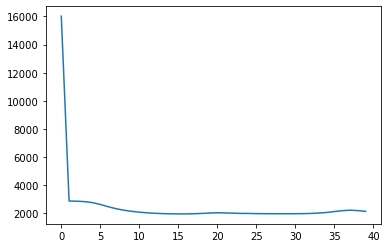

In [329]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [330]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': '),
    tokens = model_artm.score_tracker["top_words"].last_tokens # Поправка на новую версию библиотеки
    #     for word in model_artm.score_tracker["top_words"].last_topic_info[topic_name].tokens:
    line = ''
    for word in tokens[topic_name]: # Поправка для более удобного вывода
        line += word + ' '
#         line.append(' ')
#         print(word.rstrip('\n'))
    print('\t', line)

sbj0: 
	 который быть что это этот человек как свой для они его весь такой время год 
sbj1: 
	 y x a многочлен b выражение квадрат множитель скобка умножение функция f целый симметричный разность 
sbj2: 
	 обособление куприн слово раскольников мастер роман словосочетание маргарита подчинительный соня вера оборот браслет старик сантьяго 
sbj3: 
	 год государство свой время который быть северный война становиться мир россия страна территория африка развитие 
sbj4: 
	 x a b уравнение дробь y квадратный степень функция число f корень решение c пример 
sbj5: 
	 быть пушкин год свой его империя трение поэт русский характер функция ребенок язык звук существительное 
sbj6: 
	 сила тело энергия поле географический наречие частица ядерный заряд величина контур площадь вода вещество экологический 
sbj7: 
	 который что быть это как человек для этот такой свой являться мочь себя они весь 
sbj8: 
	 быть который что это свой этот как для человек они такой государство весь x являться 
sbj9: 
	 который

Давайте посмотрим также на разреженность матриц:

In [331]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.732406735420227
0.12210526317358017


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [332]:
# model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary_name="dictionary"))
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary)) #поправка на новую версию библиотеки
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [333]:
# model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15, num_document_passes=1)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=35) #поправка на новую версию библиотеки

Попробуем менять коэффициент регуляризации:

In [269]:
model_artm.regularizers['SparsePhi'].tau = -5000

In [270]:
# model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15, num_document_passes=1)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=35)

In [334]:
# регуляризация при практически любых значениях уменьшает количество тем

for topic_name in model_artm.topic_names:
    try:
        print(topic_name + ': '),
        tokens = model_artm.score_tracker["top_words"].last_tokens
    #     for word in model_artm.score_tracker["top_words"].last_topic_info[topic_name].tokens:
        line = ''
        for word in tokens[topic_name]: # Поправка для более удобного вывода
            line += word + ' '
    #         line.append(' ')
    #         print(word.rstrip('\n'))
        print('\t', line)
    except:
        print('deleted')

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


sbj0: 
	 быть который год государство время этот также y x вода для становиться часть территория новый 
sbj1: 
deleted
sbj2: 
	 обособление куприн слово раскольников мастер роман словосочетание маргарита подчинительный соня оборот браслет вера управление зависимое 
sbj3: 
	 который быть год государство для время этот также страна война территория становиться право весь россия 
sbj4: 
	 x a b функция число уравнение корень дробь f y квадратный степень точка получать если 
sbj5: 
	 быть пушкин трение год предложение существительное звук империя падеж язык плазма пример are восстание время 
sbj6: 
deleted
sbj7: 
	 что который человек это свой как быть его себя этот такой жизнь для мочь она 
sbj8: 
	 быть который что это как свой этот человек x для они a такой при его 
sbj9: 
	 который быть что этот это человек как свой весь для такой его жизнь они год 


In [256]:
# еще раз посмотрим на разреженность
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.8032524585723877
0.5334736704826355


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [87]:
model_artm.save("my_model")

In [88]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [89]:
phi = model_artm.get_phi()

In [90]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
домохозяйка,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000020
институт,0.0,0.0,0.0,0.000774,0.0,0.000000,0.0,0.000254,0.0,0.000081
машинка,0.0,0.0,0.0,0.000000,0.0,0.000127,0.0,0.000000,0.0,0.000000
прочий,0.0,0.0,0.0,0.000000,0.0,0.000054,0.0,0.000151,0.0,0.000074
навязнуть,0.0,0.0,0.0,0.000000,0.0,0.000127,0.0,0.000039,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
монблан,0.0,0.0,0.0,0.000000,0.0,0.000127,0.0,0.000000,0.0,0.000000
гарон,0.0,0.0,0.0,0.000000,0.0,0.000127,0.0,0.000000,0.0,0.000000
аист,0.0,0.0,0.0,0.000000,0.0,0.000127,0.0,0.000000,0.0,0.000000
корсиканский,0.0,0.0,0.0,0.000000,0.0,0.000127,0.0,0.000000,0.0,0.000000


Матрица вероятностей тем в документах.

In [91]:
theta = model_artm.get_theta()
theta

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,300,301,302,303,304,305,306,307,308,309,...,465,466,467,468,469,470,471,472,473,474
sbj0,4.209783e-01,6.100255e-01,5.797764e-01,7.854363e-01,2.680998e-01,6.406094e-01,4.594850e-01,4.595666e-01,4.538815e-01,6.996035e-01,...,7.333767e-09,0.026379,1.150085e-08,1.559004e-08,1.159393e-08,9.221892e-09,7.240455e-09,1.352665e-08,0.013937,0.008224
sbj1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
sbj2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.107085e-12,0.000000e+00,1.224490e-02,0.000000e+00,3.389670e-12,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
sbj3,1.073481e-07,1.123213e-07,6.462004e-08,1.890640e-07,8.045204e-08,6.436457e-08,1.488154e-07,9.051215e-08,6.887852e-08,1.387877e-07,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
sbj4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.706600e-02,0.065020,7.031221e-03,5.325645e-03,7.102972e-03,2.265282e-02,3.761412e-03,7.198858e-03,0.006215,0.011645
sbj5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.503334e-01,0.196364,1.960197e-01,1.565381e-01,1.563663e-01,3.869907e-01,1.930677e-01,1.951245e-01,0.042087,0.283261
sbj6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
sbj7,5.790167e-01,3.899702e-01,4.202179e-01,2.145601e-01,7.318957e-01,3.526226e-01,5.405104e-01,5.281829e-01,5.461140e-01,3.003889e-01,...,2.425043e-08,0.007562,1.357439e-08,8.900320e-09,3.157238e-08,1.986711e-08,4.761455e-08,1.586200e-08,0.002839,0.000010
sbj8,4.648559e-06,3.886429e-06,5.428724e-06,3.245995e-06,4.249526e-06,6.695698e-03,4.249527e-06,5.319924e-06,4.225755e-06,7.079225e-06,...,3.462463e-06,0.090124,1.932518e-06,1.976238e-06,3.046918e-06,3.244833e-06,2.758655e-06,2.041036e-06,0.061221,0.010947
sbj9,1.523704e-07,1.767926e-07,1.764227e-07,2.045440e-07,1.624989e-07,7.206220e-05,1.896655e-07,2.048736e-07,1.413496e-07,3.003219e-07,...,8.325971e-01,0.614552,7.969472e-01,8.381342e-01,8.365276e-01,5.903532e-01,8.031681e-01,7.976745e-01,0.873701,0.685913


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [92]:
# theta_test = model_artm.transform(batch_vectorizer, num_document_passes=10) - неизвестный параметр num_document_passes
theta_test = model_artm.transform(batch_vectorizer)

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: transform() got an unexpected keyword argument 'num_document_passes'